## Testing the Variogram methods

In [64]:
%load_ext autoreload
%autoreload 2

from VariogramAnalysis import VariogramAnalysis

import geostatspy.geostats as geostats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# hard code path
data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error"
file_list = os.listdir(data_dir)
file_path = os.path.join(data_dir, file_list[0])

data = pd.read_csv(file_path)
vario_ana = VariogramAnalysis(data)
bins, bins_count = vario_ana.build_variogram((0.1,0.1,1), (200,100,240), chunk_size=int(1e6))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of pairs of points: 24418777


100%|██████████| 24/24 [00:09<00:00,  2.41it/s]


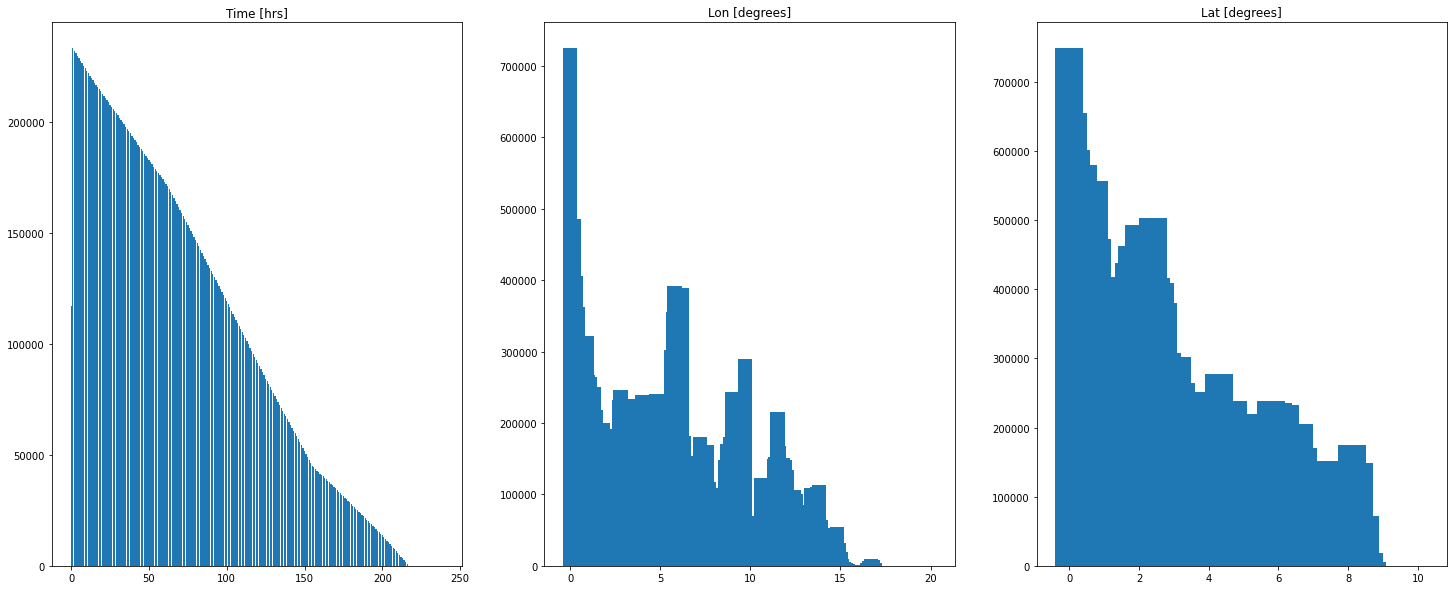

In [65]:
vario_ana.plot_histograms()

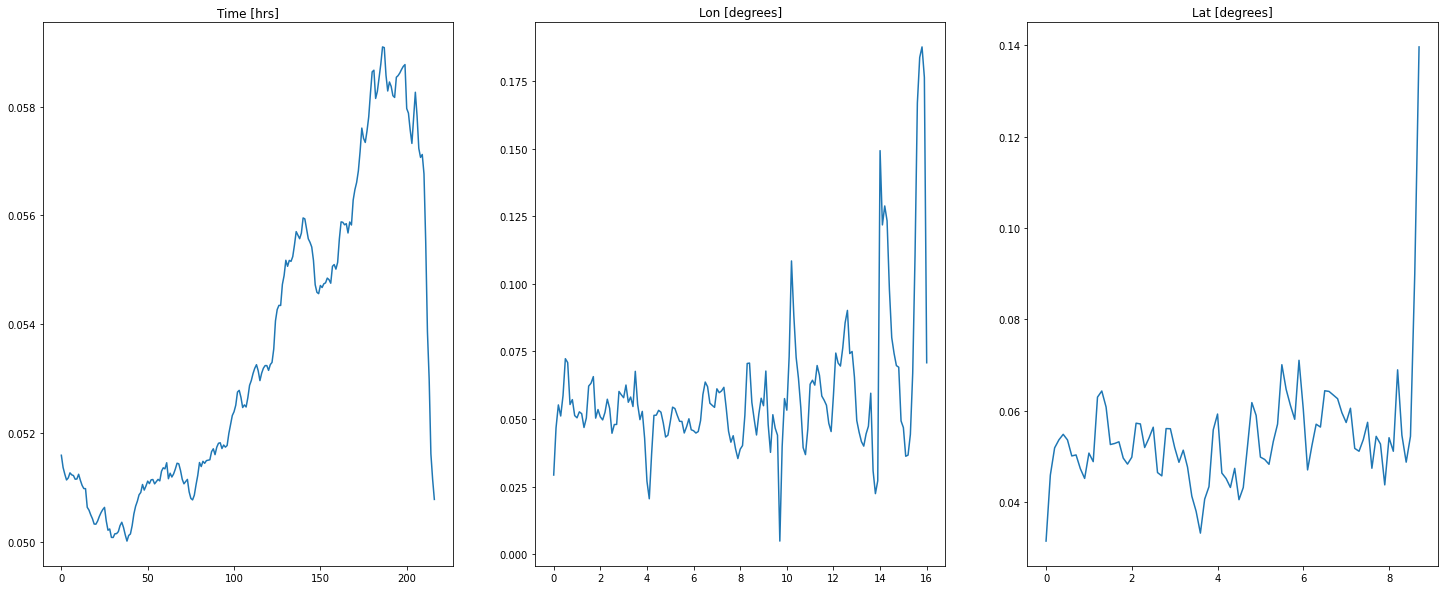

In [68]:
vario_ana.plot_variograms("u")

## Exploring detrending

In [1]:
%load_ext autoreload
%autoreload 2

from generative_model_metrics import calc_speed_mean, calc_speed_RMSE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/"
dataset_files = os.listdir(dataset_dir)

# loop over all csv files and plot errors
# detrend via latitude and plot again
for i in range(len(dataset_files)):
    if i == 0:
        df = pd.read_csv(os.path.join(dataset_dir, dataset_files[i]))
    else:
        df_temp = pd.read_csv(os.path.join(dataset_dir, dataset_files[i]))
        df = pd.concat([df, df_temp], ignore_index=True)

print(f"Num of NaN vals: {np.isnan(df['u_error']).sum()}")

Num of NaN vals: 0


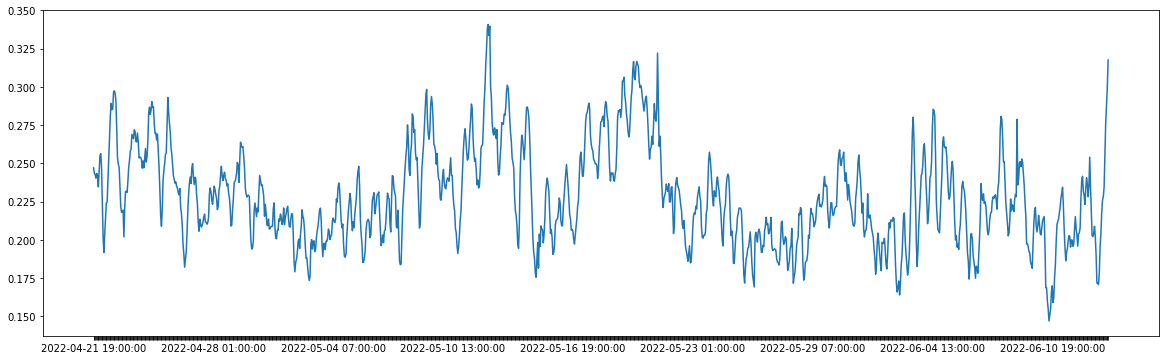

In [2]:
df["RMSE"] = calc_speed_RMSE(df["u_forecast"], df["v_forecast"], df["u"], df["v"])

df_group = df.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
plt.plot(df_group["time"], df_group["RMSE"], label="RMSE")

# needed to supress most labels
every_nth = 150
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

In [15]:
# bin data in latitude and find mean and std
# split into 5 bins
bin_labels = ["20_22", "22_24", "24_26", "26_28", "28_30"]
df["lat_bins"] = pd.cut(df["lat"], [18, 22, 24, 26, 28, 32], labels=bin_labels)

# get bin statistics
bin_statistics = {}
for bin_label in bin_labels:
    u_stats = []
    u_stats.append(df[df["lat_bins"] == bin_label]["u_error"].mean())
    u_stats.append(np.sqrt(df[df["lat_bins"] == bin_label]["u_error"].var()))

    v_stats = []
    v_stats.append(df[df["lat_bins"] == bin_label]["v_error"].mean())
    v_stats.append(np.sqrt(df[df["lat_bins"] == bin_label]["v_error"].var()))

    bin_statistics[bin_label] = {"u_error": u_stats, "v_error": v_stats}

# subtract mean and divide by std with bin statistics
df["detrended_u_error"] = df.apply(lambda x: (x["u_error"] - bin_statistics[x["lat_bins"]]["u_error"][0])/bin_statistics[x["lat_bins"]]["u_error"][1], axis=1)
df["detrended_v_error"] = df.apply(lambda x: (x["v_error"] - bin_statistics[x["lat_bins"]]["v_error"][0])/bin_statistics[x["lat_bins"]]["v_error"][1], axis=1)

{'20_22': {'u_error': [-0.08516014095083375, 0.16109805707763253], 'v_error': [-0.04075725291440432, 0.17987517529380398]}, '22_24': {'u_error': [-0.0875925009926102, 0.15757609731982394], 'v_error': [-0.0824361671014528, 0.150027005056675]}, '24_26': {'u_error': [-0.07876174338042989, 0.14432937124234407], 'v_error': [-0.07180257737659917, 0.1671813967173878]}, '26_28': {'u_error': [0.011119070975746229, 0.16138317856490103], 'v_error': [-0.1153996322356923, 0.1491022365801097]}, '28_30': {'u_error': [-0.028987960014146826, 0.20131035531570998], 'v_error': [-0.07936411138414311, 0.1839196288322338]}}


In [21]:
print(df)

                       time      lon     lat      u      v     buoy  \
0       2022-05-22 19:00:00 -123.426  22.111  0.063 -0.014  3201843   
1       2022-05-22 20:00:00 -123.426  22.113  0.077  0.014  3201843   
2       2022-05-22 21:00:00 -123.425  22.115  0.077  0.014  3201843   
3       2022-05-22 22:00:00 -123.425  22.118  0.093 -0.014  3201843   
4       2022-05-22 23:00:00 -123.426  22.120  0.062 -0.029  3201843   
...                     ...      ...     ...    ...    ...      ...   
353298  2022-05-26 06:00:00 -139.988  28.603 -0.078  0.000  5501571   
353299  2022-05-26 07:00:00 -139.988  28.600 -0.139 -0.013  5501571   
353300  2022-05-26 08:00:00 -139.990  28.594 -0.186 -0.034  5501571   
353301  2022-05-26 09:00:00 -139.992  28.587 -0.196 -0.075  5501571   
353302  2022-05-26 10:00:00 -139.998  28.582 -0.174 -0.112  5501571   

                      file_name  u_forecast  v_forecast   u_error   v_error  \
0       GL_TS_DC_3201843_202205   -0.106464   -0.147881 -0.169464 -0

# Using Geostatspy for 2D

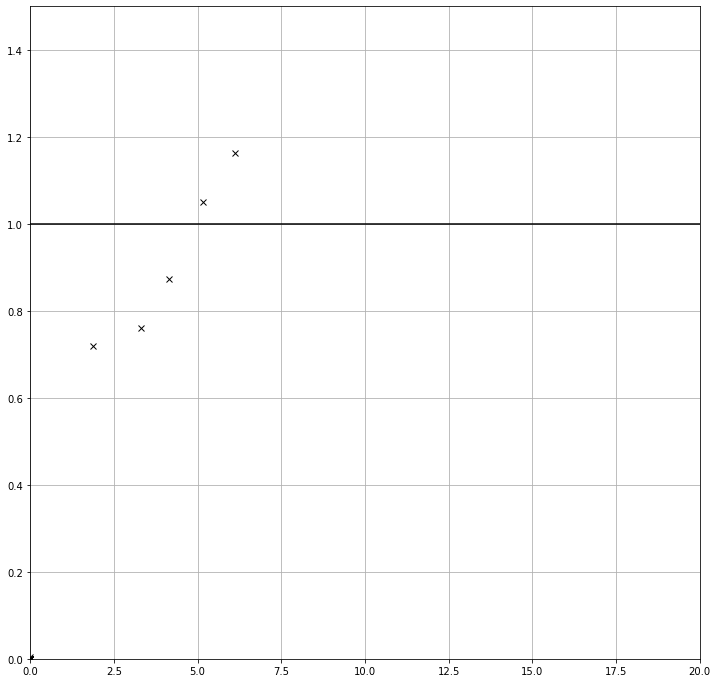

In [20]:
# set params
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 2.0; lag_tol = 4.0; nlag = 20;               # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0, 90]                                       # directions in azimuth to consider

lag, gamma, npp = geostats.gamv(
    data,
    "lon",
    "lat",
    "u_error",
    tmin,
    tmax,
    lag_dist,
    lag_tol,
    nlag,
    azi_mat[0],
    atol,
    bandh,
    isill
)

fig = plt.figure(figsize=(12,12))
plt.plot(lag, gamma, 'x', color = 'black')
plt.plot([0,20], [1.0, 1.0], color = 'black')
plt.xlim([0, 20])
plt.ylim([0, 1.5])
plt.grid(True)
plt.show()